```python
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# -----------------------------
# 설정
# -----------------------------
img_height = 32       # 셀 이미지 높이
img_width = 128       # 셀 이미지 폭
num_channels = 1      # 흑백 이미지
max_text_length = 10  # 한 셀 최대 글자 길이
characters = "0123456789DST"  # 인식할 문자 집합
num_classes = len(characters) + 1  # CTC용 blank 문자 추가

# 문자 → 인덱스
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="", invert=True)

# -----------------------------
# CNN + BiLSTM + CTC 모델
# -----------------------------
def build_model():
    input_img = layers.Input(shape=(img_height, img_width, num_channels), name='image')

    # CNN feature extractor
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # CNN 출력 → 시퀀스 변환
    new_shape = ((img_width // 4), (img_height // 4) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    
    # Output layer
    output = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = models.Model(inputs=input_img, outputs=output)
    return model

# -----------------------------
# CTC Loss 계산용 레이어
# -----------------------------
class CTCLossLayer(layers.Layer):
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len,1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')

        loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# -----------------------------
# 모델 컴파일
# -----------------------------
base_model = build_model()
labels = layers.Input(name='label', shape=(max_text_length,), dtype='float32')

output = CTCLossLayer()(labels, base_model.output)
model = models.Model(inputs=[base_model.input, labels], outputs=output)

model.compile(optimizer='adam')
model.summary()

# -----------------------------
# 데이터 준비 예시
# -----------------------------
# X: (num_samples, img_height, img_width, 1)
# y: (num_samples, max_text_length) 정수 인덱스
# 실제 학습 시에는 셀 이미지를 crop해서 resize 후 char_to_num으로 변환

# X_dummy = np.random.rand(32, img_height, img_width, 1).astype(np.float32)
# y_dummy = np.random.randint(0, num_classes, size=(32, max_text_length))

# model.fit([X_dummy, y_dummy], y_dummy, epochs=10, batch_size=8)

In [5]:
from pandas import CategoricalDtype, read_csv
import pandas as pd

# -------------------------
# 1. 설정 정의
# -------------------------

# CSV key 목록
RE_KEYS = ('DE', 'DR', 'V')

# 기본 숫자 변환기
parse_int = lambda x: int(x) if x else 0
parse_int_comma = lambda x: int(x.replace(',', '')) if x else 0

# CSV 컬럼별 변환 함수
CONVERTERS = {
    'T': lambda x: int(x) if x else 1,
    'R': lambda x: x if x else 'A',
    'E': parse_int,
    'A': parse_int,
    'DE': parse_int,
    'DA': parse_int_comma,
    'H': parse_int_comma,
    'M': parse_int_comma,
}

# 컬럼별 dtype
DTYPES = {
    'T': CategoricalDtype((1, 2)),
    'R': CategoricalDtype(('A', 'T', 'D', 'S')),
    'E': 'uint8',
    'A': 'uint8',
    'DE': 'uint8',
    'DA': 'uint16',
    'H': 'uint16',
    'M': 'uint16'
}


# -------------------------
# 2. CSV 데이터 읽기 & 병합
# -------------------------

def load_re_data():
    df_list = []
    for key in RE_KEYS:
        df = read_csv(f'R/{key}.csv', index_col=0, converters=CONVERTERS)
        df = df.astype(DTYPES, copy=False)
        df_list.append(df)
    return pd.concat(df_list, keys=RE_KEYS, names=('RE',))


df = load_re_data()
df

T  R   E  A  DE    DA     H     M
RE I                                     
DE 1    1  T   0  0   8  2947  1425  4611
   1    1  D   1  0   3  1818     0   650
   1    1  D   2  0   7  4735   487   308
   1    1  S   1  0   3  2078  2748     0
   1    1  S   1  1   3   269  5848   189
...    .. ..  .. ..  ..   ...   ...   ...
V  467  2  T   7  2   4  6453     0  9665
   467  2  D  10  0   5  6272    62  1417
   467  2  D   6  1   7  5267    78    76
   467  2  S   5  1   6  4602  8211   716
   467  2  S   2  5   7  1979  7396   329

[9110 rows x 8 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9110 entries, ('DE', np.int64(1)) to ('V', np.int64(467))
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   T       9110 non-null   category
 1   R       9110 non-null   category
 2   E       9110 non-null   uint8   
 3   A       9110 non-null   uint8   
 4   DE      9110 non-null   uint8   
 5   DA      9110 non-null   uint16  
 6   H       9110 non-null   uint16  
 7   M       9110 non-null   uint16  
dtypes: category(2), uint16(3), uint8(3)
memory usage: 144.9+ KB


In [7]:
# -------------------------
# 3. 첫 2개 컬럼은 범주형 → 코드화
#    나머지 숫자 컬럼은 자리수별로 분해
# -------------------------

category_cols = df.columns[:2].to_list()
numeric_cols = df.columns[2:].to_list()
category_cols, numeric_cols

(['T', 'R'], ['E', 'A', 'DE', 'DA', 'H', 'M'])

In [10]:
from pandas import DataFrame
from math import floor, log10


def split_digits(series: pd.Series) -> DataFrame:
    """정수 Series를 각 자리수로 나누어 DataFrame 반환"""
    max_value = series.max()
    max_digit = floor(log10(max_value)) if max_value > 0 else 0

    result = {}
    for pos in range(max_digit, -1, -1):
        result[f'{series.name}{pos}'] = (series // 10 ** pos % 10).astype('uint8', copy=False)
    return DataFrame(result)


# 최종 변환 테이블
encoded = DataFrame({col: df[col].cat.codes.astype('uint8', copy=False) for col in category_cols})

for col in numeric_cols:
    encoded = pd.concat([encoded, split_digits(df[col])], axis=1)

encoded

T  R  E1  E0  A1  A0  DE1  DE0  DA4  DA3  ...  H4  H3  H2  H1  H0  M4  \
RE I                                              ...                           
DE 1    0  1   0   0   0   0    0    8    0    2  ...   0   1   4   2   5   0   
   1    0  2   0   1   0   0    0    3    0    1  ...   0   0   0   0   0   0   
   1    0  2   0   2   0   0    0    7    0    4  ...   0   0   4   8   7   0   
   1    0  3   0   1   0   0    0    3    0    2  ...   0   2   7   4   8   0   
   1    0  3   0   1   0   1    0    3    0    0  ...   0   5   8   4   8   0   
...    .. ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ..  ..  ..  ..  ..  ..   
V  467  1  1   0   7   0   2    0    4    0    6  ...   0   0   0   0   0   0   
   467  1  2   1   0   0   0    0    5    0    6  ...   0   0   0   6   2   0   
   467  1  2   0   6   0   1    0    7    0    5  ...   0   0   0   7   8   0   
   467  1  3   0   5   0   1    0    6    0    4  ...   0   8   2   1   1   0   
   467  1  3   0   2   0   5    0    7    0    1  ...   0   7   3   9   6   0   

        M3  M2  M1  M0  
RE I                    
DE 1     4   6   1   1  
   1     0   6   5   0  
   1     0   3   0   8  
   1     0   0   0   0  
   1     0   1   8   9  
...     ..  ..  ..  ..  
V  467   9   6   6   5  
   467   1   4   1   7  
   467   0   0   7   6  
   467   0   7   1   6  
   467   0   3   2   9  

[9110 rows x 23 columns]

In [11]:
encoded.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9110 entries, ('DE', np.int64(1)) to ('V', np.int64(467))
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   T       9110 non-null   uint8
 1   R       9110 non-null   uint8
 2   E1      9110 non-null   uint8
 3   E0      9110 non-null   uint8
 4   A1      9110 non-null   uint8
 5   A0      9110 non-null   uint8
 6   DE1     9110 non-null   uint8
 7   DE0     9110 non-null   uint8
 8   DA4     9110 non-null   uint8
 9   DA3     9110 non-null   uint8
 10  DA2     9110 non-null   uint8
 11  DA1     9110 non-null   uint8
 12  DA0     9110 non-null   uint8
 13  H4      9110 non-null   uint8
 14  H3      9110 non-null   uint8
 15  H2      9110 non-null   uint8
 16  H1      9110 non-null   uint8
 17  H0      9110 non-null   uint8
 18  M4      9110 non-null   uint8
 19  M3      9110 non-null   uint8
 20  M2      9110 non-null   uint8
 21  M1      9110 non-null   uint8
 22  M0      9110 n

In [12]:
# 전체 열을 10단위 길이 벡터로 변환
reshaped = tuple(encoded.to_numpy().reshape(-1, encoded.shape[1] * 10).T)
len(reshaped)

230

2025-11-19 02:31:00.151128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763519460.343701     236 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763519460.407637     236 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763519460.934620     236 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763519460.934695     236 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763519460.934697     236 computation_placer.cc:177] computation placer alr

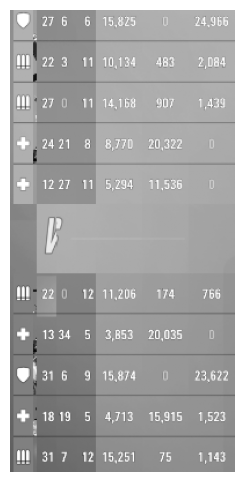

0 1 2 7 0 6 0 6 1 5 8 2 5 0 0 0 0 0 2 4 9 6 6 0 2 2 2 0 3 1 1 1 0 1 3 4 0 0 4 8 3 0 2 0 8 4 0 2 2 7 0 0 1 1 1 4 1 6 8 0 0 9 0 7 0 1 4 3 9 0 3 2 4 2 1 0 8 0 8 7 7 0 2 0 3 2 2 0 0 0 0 0 0 3 1 2 2 7 1 1 0 5 2 9 4 1 1 5 3 6 0 0 0 0 0 1 2 2 2 0 0 1 2 1 1 2 0 6 0 0 1 7 4 0 0 7 6 6 1 3 1 3 3 4 0 5 0 3 8 5 3 2 0 0 3 5 0 0 0 0 0 1 1 3 1 0 6 0 9 1 5 8 7 4 0 0 0 0 0 2 3 6 2 2 1 3 1 8 1 9 0 5 0 4 7 1 3 1 5 9 1 5 0 1 5 2 3 1 2 3 1 0 7 1 2 1 5 2 5 1 0 0 0 7 5 0 1 1 4 3


2025-11-19 02:31:11.571865: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
from pathlib import Path
import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
from matplotlib.pyplot import figure, axis, imshow, show


# ==========================
# 이미지 전처리 함수
# ==========================

def preprocess_image(path, label):
    """PNG 이미지 파일을 읽고 필요한 부분을 추출 및 리사이즈."""
    image = decode_png(read_file(path), channels=1)[230:930, 530:1370]
    # 필요한 HUD 영역만 선택
    hud_parts = [
        image[:, :40], image[:, 390:420], image[:, 450:480],
        image[:, 500:530], image[:, 570:640], image[:, 670:740], image[:, 770:]
    ]
    cropped = tf.concat(hud_parts, axis=1)
    resized = resize(cropped, (400, 194)) / 255
    return resized, label


# ==========================
# Dataset 생성
# ==========================

image_paths = sorted(map(str, Path().rglob('*.png')))
data_count = len(reshaped)

dataset = (
    Dataset.from_tensor_slices((image_paths, reshaped))
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(data_count)
)

train_size = int(data_count * 0.9)
train_ds = dataset.take(train_size).batch(32).prefetch(AUTOTUNE)
val_ds = dataset.skip(train_size).batch(32).prefetch(AUTOTUNE)

# ==========================
# 샘플 시각화
# ==========================

for x_batch, y_batch in train_ds.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep=' ')

In [15]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import AdamW

clear_session()

# ==========================
# CNN 백본 모델 정의
# ==========================

input_tensor = Input(shape=x_batch.shape[1:])

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(256, use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(.4)(x)

# ==========================
# 다중 출력층 생성
# ==========================

nunique_dict = encoded.nunique().to_dict()
outputs = []
for i in range(10):
    for key in nunique_dict:
        if nunique_dict[key] <= 2:
            outputs.append(Dense(1, name=f'{key}_{i}')(x))
        else:
            outputs.append(Dense(nunique_dict[key], name=f'{key}_{i}')(x))
model = Model(inputs=input_tensor, outputs=outputs)

# ==========================
# 모델 컴파일
# ==========================

loss = {}
for i in range(10):
    for key in nunique_dict:
        if nunique_dict[key] <= 2:
            loss[f'{key}_{i}'] = BinaryCrossentropy(True)
        else:
            loss[f'{key}_{i}'] = SparseCategoricalCrossentropy(True)
metrics = {}
for i in range(10):
    for key in nunique_dict:
        metrics[f'{key}_{i}'] = 'accuracy'
model.compile(AdamW(1e-4, 1e-5), loss, metrics=metrics)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 194,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 400, 194,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 400, 194,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 400, 194,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 200, 97,   │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 97,   │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 97,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 200, 97,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 100, 48,   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 48,   │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 48,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 100, 48,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 24,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 153600)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 39,321,600 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ re_lu_3[0][0]   

 Total params: 39,881,138 (152.13 MB)

 Trainable params: 39,880,178 (152.13 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
from tensorflow.keras.callbacks import Callback, EarlyStopping
from numpy import mean


# ==========================
# 모델 학습
# ==========================

class TypeAveragingLogger(Callback):
    def __init__(self, output_types=nunique_dict):
        super().__init__()
        self.output_types = output_types

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f'\n=== 평균 손실 및 정확도 (Epoch {epoch + 1}) ===')

        for t in self.output_types:
            # 각 타입별 키 필터링
            loss_keys = [k for k in logs.keys() if k.startswith(f'val_{t}_') and k.endswith('_loss')]
            acc_keys = [k for k in logs.keys() if k.startswith(f'val_{t}_') and ('accuracy' in k or 'acc' in k)]

            # 평균 계산
            if loss_keys:
                mean_loss = mean([logs[k] for k in loss_keys])
                print(f' {t} 평균 val_loss: {mean_loss:.4f}')
            if acc_keys:
                mean_acc = mean([logs[k] for k in acc_keys])
                print(f' {t} 평균 val_accuracy: {mean_acc:.4f}')

        print('=' * 40)


# EarlyStopping 콜백 설정
early_stop = EarlyStopping(  # 검증 손실 기준으로 모니터링
    patience=8,  # patience 동안 개선 없으면 종료
    verbose=1,
    restore_best_weights=True  # 가장 성능 좋았던 가중치로 복원
)

# 학습
history = model.fit(
    train_ds,
    epochs=256,
    verbose=0,
    validation_data=val_ds,
    callbacks=(TypeAveragingLogger(), early_stop)
)

I0000 00:00:1763519674.149360     343 service.cc:152] XLA service 0x7ba180232610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763519674.149412     343 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-11-19 02:34:36.306055: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763519682.987078     343 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763519733.049804     343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-19 02:36:49.991454: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_228', 8 bytes spill stores, 8 bytes spill loads




=== 평균 손실 및 정확도 (Epoch 1) ===
 T 평균 val_loss: 0.7145
 T 평균 val_accuracy: 0.5080
 R 평균 val_loss: 1.5270
 R 평균 val_accuracy: 0.0196
 E1 평균 val_loss: 1.7832
 E1 평균 val_accuracy: 0.1957
 E0 평균 val_loss: 2.3250
 E0 평균 val_accuracy: 0.0940
 A1 평균 val_loss: 1.9520
 A1 평균 val_accuracy: 0.0580
 A0 평균 val_loss: 2.3117
 A0 평균 val_accuracy: 0.1382
 DE1 평균 val_loss: 1.0673
 DE1 평균 val_accuracy: 0.3865
 DE0 평균 val_loss: 2.3149
 DE0 평균 val_accuracy: 0.0984
 DA4 평균 val_loss: 1.0915
 DA4 평균 val_accuracy: 0.4611
 DA3 평균 val_loss: 2.3176
 DA3 평균 val_accuracy: 0.1027
 DA2 평균 val_loss: 2.3157
 DA2 평균 val_accuracy: 0.0989
 DA1 평균 val_loss: 2.3150
 DA1 평균 val_accuracy: 0.1058
 DA0 평균 val_loss: 2.3141
 DA0 평균 val_accuracy: 0.1092
 H4 평균 val_loss: 1.0755
 H4 평균 val_accuracy: 0.3702
 H3 평균 val_loss: 2.3041
 H3 평균 val_accuracy: 0.1358
 H2 평균 val_loss: 2.3018
 H2 평균 val_accuracy: 0.1486
 H1 평균 val_loss: 2.3003
 H1 평균 val_accuracy: 0.0727
 H0 평균 val_loss: 2.3260
 H0 평균 val_accuracy: 0.0962
 M4 평균 val_loss: 1.3866

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


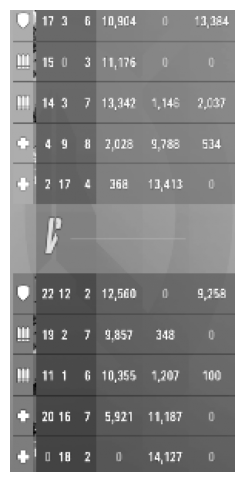

0.0 1.0 0.2982456 0.048387095 0.26086956 0.36441416 0.0 0.39019272 0.0 2.0 0.2631579 0.0 0.13043478 0.37350443 0.0 0.0 0.0 2.0 0.24561404 0.048387095 0.3043478 0.44589266 0.043377873 0.059386022 0.0 3.0 0.07017544 0.14516129 0.3478261 0.06777622 0.37049094 0.015568059 0.0 3.0 0.03508772 0.27419356 0.17391305 0.012298644 0.50770277 0.0 1.0 1.0 0.3859649 0.19354838 0.08695652 0.41975805 0.0 0.26990467 1.0 2.0 0.33333334 0.032258064 0.3043478 0.32942316 0.013172338 0.0 1.0 2.0 0.19298245 0.016129032 0.26086956 0.34606645 0.045686815 0.0029153668 1.0 3.0 0.3508772 0.2580645 0.3043478 0.19788116 0.42344525 0.0 1.0 3.0 0.0 0.29032257 0.08695652 0.0 0.53472877 0.0


2025-11-16 06:31:24.817139: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
from numpy import array

for x_batch, y_batch in val_ds.take(1):
    x_sample = x_batch[0:1]
    y_sample = tuple(y[0] for y in y_batch)
    y_pred = model.predict(x_sample)
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep=' ')

In [15]:
import numpy as np

In [16]:
y_sample_ = (array(y_sample).reshape(-1, 8) * ([1, 1] + numeric_max.tolist())).round().astype('uint16')
y_sample_

array([[    0,     1,    17,     3,     6, 10904,     0, 13384],
       [    0,     2,    15,     0,     3, 11176,     0,     0],
       [    0,     2,    14,     3,     7, 13342,  1146,  2037],
       [    0,     3,     4,     9,     8,  2028,  9788,   534],
       [    0,     3,     2,    17,     4,   368, 13413,     0],
       [    1,     1,    22,    12,     2, 12560,     0,  9258],
       [    1,     2,    19,     2,     7,  9857,   348,     0],
       [    1,     2,    11,     1,     6, 10355,  1207,   100],
       [    1,     3,    20,    16,     7,  5921, 11187,     0],
       [    1,     3,     0,    18,     2,     0, 14127,     0]],
      dtype=uint16)

In [17]:
print(f'T R  E  A DE  DA    H    M')
for i in range(10):
    print(f'{int(y_pred[0 + i * 8][0][0] >= 0.5):1d}', end=' ')
    print(f'{y_pred[1 + i * 8][0].argmax():1d}', end=' ')
    print(f'{int((y_pred[2 + i * 8][0][0] * numeric_max[0]).round()):2d}', end=' ')
    print(f'{int((y_pred[3 + i * 8][0][0] * numeric_max[1]).round()):2d}', end=' ')
    print(f'{int((y_pred[4 + i * 8][0][0] * numeric_max[2]).round()):1d}', end=' ')
    print(f'{int((y_pred[5 + i * 8][0][0] * numeric_max[3]).round()):4d}', end=' ')
    print(f'{int((y_pred[6 + i * 8][0][0] * numeric_max[4]).round()):4d}', end=' ')
    print(f'{int((y_pred[7 + i * 8][0][0] * numeric_max[5]).round()):4d}', end=' ')
    print()

T R  E  A DE  DA    H    M
0 1  2  1 1 1034  151 1213 
0 2  1  2 0 1280 -127 -715 
0 2  2  1 1  116    3 -121 
0 3  1  1 1  329  498  121 
0 3  0  1 1  189  864 -471 
1 1  3  1 1 1161  -20  488 
1 2  1  1 0 1063  325   -4 
1 2  1 -1 1 1419  630 -297 
1 3  1  2 1  158  777 -338 
1 3  2  3 1  180 1135 1589 


자릿수 나눠서 학습해 보자! 가능성이 있다!